In [ ]:
%load_ext Cython

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Numerov algorithm

Numerov algorithm

In [ ]:
def numerov_slow(numpoints: int, psiinit: np.array, E, V: np.array, h: float) -> np.array:
    """
    Numerov algorithm for the solution of the Schrödinger equation
    """
    psi = np.zeros(numpoints, dtype=np.float64)
    psi[0:2] = psiinit
    
    for i in np.arange(1, numpoints-1):
        psi[i+1] = 1 / ( 1 + h**2 * (E-V[i+1]) / 12 ) *\
                   ( psi[i] * (2 - 5 / 3 * h**2 * (E-V[i]) ) -\
                   psi[i-1] * ( 1 + h**2 * (E-V[i-1]) / 6 ) )
    return psi

Numerov algorithm, compiled in cython produces a ~100x performance boost

In [ ]:
%%cython -a
import numpy as np

def numerov(int numpoints, double[:] psiinit,double E,double[:] V,double h):
    """
    Numerov algorithm for the solution of the Schrödinger equation, implemented in Cython
    """
    psi = np.zeros(numpoints, dtype = np.double)
    cdef double[:] psi_c = psi
    psi_c[0] = psiinit[0]
    psi_c[1] = psiinit[1]

    cdef int i
    for i in range(1, numpoints-1):
        psi_c[i+1] = 1 / ( 1 + h*h * (E-V[i+1]) / 6 ) *\
                   ( psi_c[i] * (2 - 5 / 3 * h*h * (E-V[i]) ) -\
                   psi_c[i-1] * ( 1 + h*h * (E-V[i-1]) / 6 ) )
    return psi 

# Problem parameters

In [ ]:
# conversion to adimensional units, when will be needed

hbar = 0
mass = 0
length = 0
omega_dim = 0

# omega = omega_dim*mass*length*length/hbar/hbar
omegasq = 1 #omega^2 in the potential

In [ ]:
numpoints = 100000 #odd value to have 0 as one of the points of the mesh
x_interval = np.array([0,5])
h = (x_interval[1]-x_interval[0])/numpoints #spacing of the mesh
x_interval = x_interval + h

# mesh_start = np.array([0.,h/1000.], dtype = np.double)
mesh_start = np.array([0.,h], dtype = np.double)

x = np.linspace(x_interval[0], x_interval[1], numpoints)
l = 1
V = 1/2*omegasq*x**2 + l*(l+1)/x**2 #harmonic potential

energy_min = 0
energy_max = 20
energy_step = 0.01
spectrum = np.arange(energy_min, energy_max, energy_step)


# Analisys on the spectrum

## Coarse analisys

to find upper and lower bounds for the nodes

In [ ]:
hbv = np.zeros(np.size(spectrum)) #vector storing values of psi at penultimate points for different n

for counter, E in enumerate(spectrum):
    
    psi = numerov(numpoints, mesh_start, E, V, h)
    hbv[counter] = psi[numpoints-1]

(-10.0, 10.0)

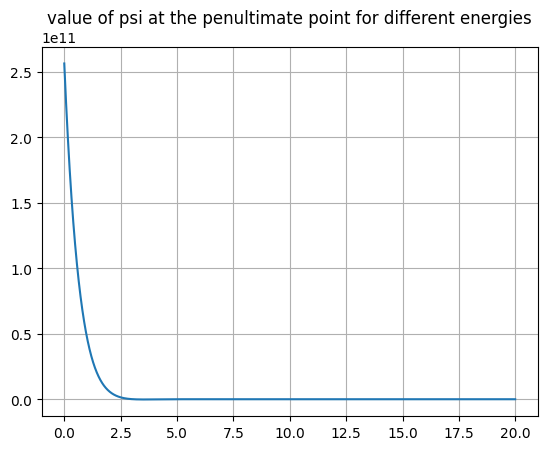

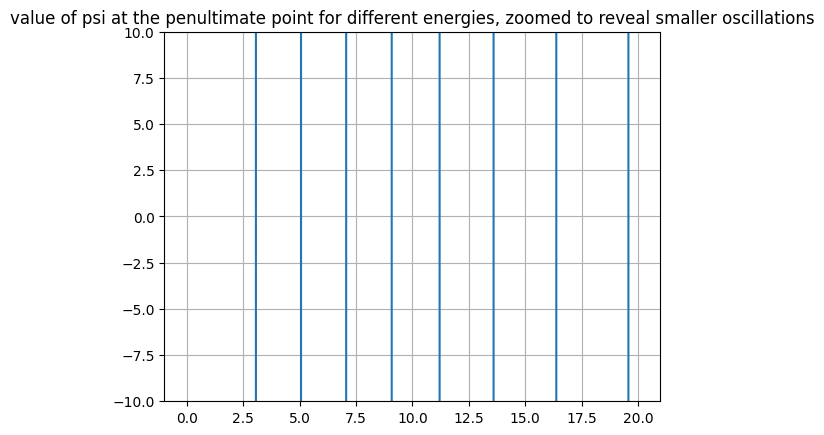

In [ ]:
figtot, axtot = plt.subplots()
axtot.plot(spectrum, hbv, '-')
axtot.set_title("value of psi at the penultimate point for different energies")
plt.grid()

figfine, axfine = plt.subplots()
axfine.plot(spectrum, hbv, '-')
axfine.set_title("value of psi at the penultimate point for different energies, zoomed to reveal smaller oscillations")
plt.grid()
axfine.set_ylim(-10, 10)

## Fine analisys

to find a result for the nodes exact to a specified treshold

In [ ]:
# easy way to find the indexes at which the sign of hbv switches (which is where the nodes are)
nodes_first_index = np.where(np.diff(np.sign(hbv)))[0]


In [ ]:
treshold = 1e-4
numnodes = np.size(nodes_first_index)
eigf=np.zeros((numnodes, numpoints))#eigenfunctions
eigv=np.zeros(numnodes)#eigenvalues

for i1 in range(numnodes): # looping on the nodes to find values precise up to treshold
    e1 = spectrum[nodes_first_index[i1]]
    e2 = spectrum[nodes_first_index[i1] + 1]
    hbv1 = hbv[nodes_first_index[i1]]
    hbv2 = hbv[nodes_first_index[i1]+1]
    Goodenough = False
    counter = 0
    while not Goodenough:
        e3 = (e2+e1)/2
        psi = numerov(numpoints, mesh_start, e3, V, h)
        hbv3 = psi[numpoints-1]
        if np.sign(hbv3) == np.sign(hbv1):
            e1 = e3
            hbv1 = hbv3
        else: 
            e2 = e3
            hbv2 = hbv3
        if np.abs(e1-e2) < treshold: # when treshold satisfied the result gets saved
            Goodenough = True
            eigv[i1] = (e1+e2)/2
            eigf[i1, :] = psi
        sys.stdout.write("\r" + "node number : " + str(i1) + " of: " + str(numnodes) + " iteration: " + str(counter))
        sys.stdout.flush()
        counter += 1
    print("\n")



node number : 0 of: 8 iteration: 6

node number : 1 of: 8 iteration: 6

node number : 2 of: 8 iteration: 6

node number : 3 of: 8 iteration: 6

node number : 4 of: 8 iteration: 6

node number : 5 of: 8 iteration: 6

node number : 6 of: 8 iteration: 6

node number : 7 of: 8 iteration: 6



Finally results can be plotted

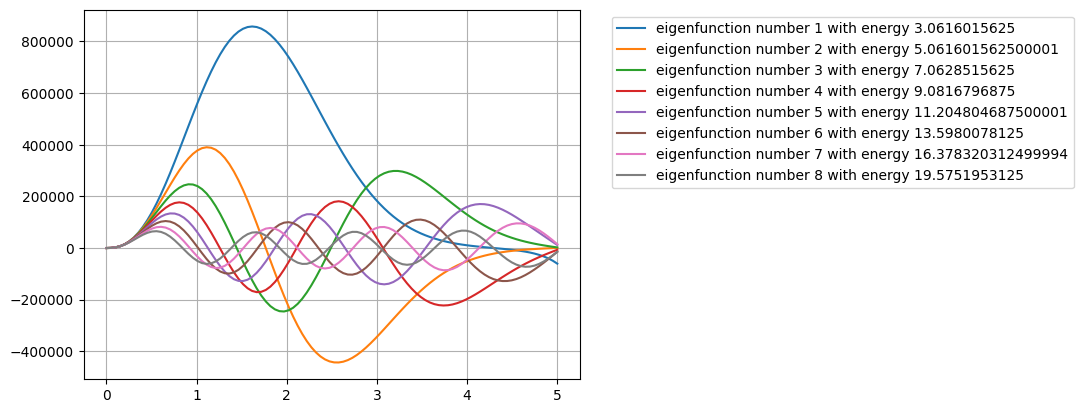

In [ ]:
fig, ax = plt.subplots()
samplerate = 1000
x_toplot = np.linspace(x_interval[0], x_interval[1], int(numpoints/samplerate))

for i in range(numnodes):
    toplot = eigf[i, ::samplerate]
    ax.plot(x_toplot, toplot, label="eigenfunction number " + str(i+1) + " with energy " + str(eigv[i]))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e4126dc-f129-4e98-a27d-950fd08f732c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>